In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib as plt
%matplotlib inline

a = QuantumRegister(12, name='q')  
carry = QuantumRegister(3, name='carry')  
sum_qubits = QuantumRegister(8, name='sum')  
ancilla = QuantumRegister(11, 'ancilla')
cl = ClassicalRegister(12, 'c')  
qreg_b = QuantumRegister(3, 'limit')

qc = QuantumCircuit(a, carry, sum_qubits, qreg_b, ancilla, cl)

# Step 1: Initialization with Hadamard gates for node qubits
for i in range(12):
    qc.h(a[i])

# ORACLE 
# Node 1 and Node 2
qc.ccx(a[0], a[3], ancilla[0])
qc.ccx(a[1], a[4], ancilla[0])
qc.ccx(a[2], a[5], ancilla[0])

qc.barrier()

# Node 1 and Node 3
qc.ccx(a[0], a[6], ancilla[1])
qc.ccx(a[1], a[7], ancilla[1])
qc.ccx(a[2], a[8], ancilla[1])

qc.barrier()

# Node 2 and Node 4
qc.ccx(a[3], a[9], ancilla[2])
qc.ccx(a[4], a[10], ancilla[2])
qc.ccx(a[5], a[11], ancilla[2])

qc.barrier()

# Node 3 and Node 4
qc.ccx(a[6], a[9], ancilla[3])
qc.ccx(a[7], a[10], ancilla[3])
qc.ccx(a[8], a[11], ancilla[3])

qc.barrier()

#ORACLE 2
#Processing Time Node 1 (011 3 hours)
qc.x(a[0])
qc.x(a[1])
    
#Processing Time Node 2 (010 2 hours)
qc.x(a[4])
    
#Processing Time Node 3 (011 3 hours)
qc.x(a[6])
qc.x(a[7])
    
#Processing Time Node 4 (100 4 hours)
qc.x(a[11])


# Summation Node 1 and Node 4
# First bit (least significant bit)
qc.cx(a[0], sum_qubits[0])
qc.cx(a[9], sum_qubits[0])
qc.ccx(a[0], a[9], carry[0])

# Second bit
qc.cx(a[1], sum_qubits[1])
qc.cx(a[10], sum_qubits[1])
qc.ccx(a[1], a[10], carry[1])
qc.cx(carry[0], sum_qubits[1])
qc.ccx(sum_qubits[1], carry[0], carry[1])

# Third bit
qc.cx(a[2], sum_qubits[2])
qc.cx(a[11], sum_qubits[2])
qc.ccx(a[2], a[11], carry[2])
qc.cx(carry[1], sum_qubits[2])
qc.ccx(sum_qubits[2], carry[1], carry[2])
qc.cx(carry[2], sum_qubits[3])  # Most significant carry

qc.barrier()

# Summation Node 2 and Node 3
# First bit (least significant bit)
qc.cx(a[3], sum_qubits[4])
qc.cx(a[6], sum_qubits[4])
qc.ccx(a[3], a[6], carry[0])

# Second bit
qc.cx(a[4], sum_qubits[5])
qc.cx(a[7], sum_qubits[5])
qc.ccx(a[4], a[7], carry[1])
qc.cx(carry[0], sum_qubits[5])
qc.ccx(sum_qubits[5], carry[0], carry[1])

# Third bit
qc.cx(a[5], sum_qubits[6])
qc.cx(a[8], sum_qubits[6])
qc.ccx(a[5], a[8], carry[2])
qc.cx(carry[1], sum_qubits[6])
qc.ccx(sum_qubits[6], carry[1], carry[2])
qc.cx(carry[2], sum_qubits[6])  # Most significant carry

qc.barrier()

# Comparison
# Function to create U< gate
def create_U_less():
    qc = QuantumCircuit(3, name='U<')
    qc.x(0)
    qc.ccx(0, 1, 2)
    qc.cx(1, 2)
    return qc.to_gate()

# Function to create U0 gate
def create_U_equal():
    qc = QuantumCircuit(3, name='U0')
    qc.x(1)
    qc.ccx(0, 1, 2)
    qc.x(1)
    return qc.to_gate()

#binary b 110 6 hours
qc.x(qreg_b[1])
qc.x(qreg_b[2])

#node 1 and node 4
# Apply U< gates
qc.append(create_U_less(), [sum_qubits[0], qreg_b[0], ancilla[4]])
qc.append(create_U_less(), [sum_qubits[1], qreg_b[1], ancilla[5]])
qc.append(create_U_less(), [sum_qubits[2], qreg_b[2], ancilla[6]])

# Controlled operations based on U< results
qc.ccx(qreg_b[0], ancilla[5], ancilla[4]) 

# Apply U0 gates
qc.append(create_U_equal(), [sum_qubits[1], qreg_b[1], ancilla[5]])

qc.ccx(qreg_b[0], qreg_b[1], ancilla[5])
qc.ccx(ancilla[6], ancilla[5], ancilla[4])

qc.append(create_U_equal(), [sum_qubits[2], qreg_b[2], ancilla[6]])

qc.ccx(ancilla[5], qreg_b[2], ancilla[6])

qc.barrier()

#node 2 and node 3
# Apply U< gates
qc.append(create_U_less(), [sum_qubits[4], qreg_b[0], ancilla[7]])
qc.append(create_U_less(), [sum_qubits[5], qreg_b[1], ancilla[8]])
qc.append(create_U_less(), [sum_qubits[6], qreg_b[2], ancilla[9]])

# Controlled operations based on U< results
qc.ccx(qreg_b[0], ancilla[8], ancilla[7])  

# Apply U0 gates
qc.append(create_U_equal(), [sum_qubits[5], qreg_b[1], ancilla[8]])

qc.ccx(qreg_b[0], qreg_b[1], ancilla[8])
qc.ccx(ancilla[9], ancilla[8], ancilla[7])

qc.append(create_U_equal(), [sum_qubits[6], qreg_b[2], ancilla[9]])

qc.ccx(ancilla[8], qreg_b[2], ancilla[9])

qc.barrier()

qc.x(ancilla[:10])  # Invert ancilla qubits
qc.mcx(ancilla[:10], ancilla[10])  # Multi-controlled Z gate
qc.x(ancilla[:10])  # Reset ancilla qubits

qc.barrier()

# Apply Grover diffusion operator
def grover_diffusion(circuit, qubits):
    circuit.h(qubits)
    circuit.x(qubits)
    circuit.h(qubits[-1])
    circuit.mcx(qubits[:-1], qubits[-1])
    circuit.h(qubits[-1])
    circuit.x(qubits)
    circuit.h(qubits)
    
grover_diffusion(qc, a[:12])

qc.measure([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

print(qc.draw(output='text'))

            ┌───┐                ░                 ░                 ░      »
       q_0: ┤ H ├──■─────────────░───■─────────────░─────────────────░──────»
            ├───┤  │             ░   │             ░                 ░      »
       q_1: ┤ H ├──┼────■────────░───┼────■────────░─────────────────░──────»
            ├───┤  │    │        ░   │    │        ░                 ░      »
       q_2: ┤ H ├──┼────┼────■───░───┼────┼────■───░─────────────────░──────»
            ├───┤  │    │    │   ░   │    │    │   ░                 ░      »
       q_3: ┤ H ├──■────┼────┼───░───┼────┼────┼───░───■─────────────░──────»
            ├───┤  │    │    │   ░   │    │    │   ░   │             ░      »
       q_4: ┤ H ├──┼────■────┼───░───┼────┼────┼───░───┼────■────────░──────»
            ├───┤  │    │    │   ░   │    │    │   ░   │    │        ░      »
       q_5: ┤ H ├──┼────┼────■───░───┼────┼────┼───░───┼────┼────■───░──────»
            ├───┤  │    │    │   ░   │    │    │   ░   │    │   

Figure(2304.49x12993.2)


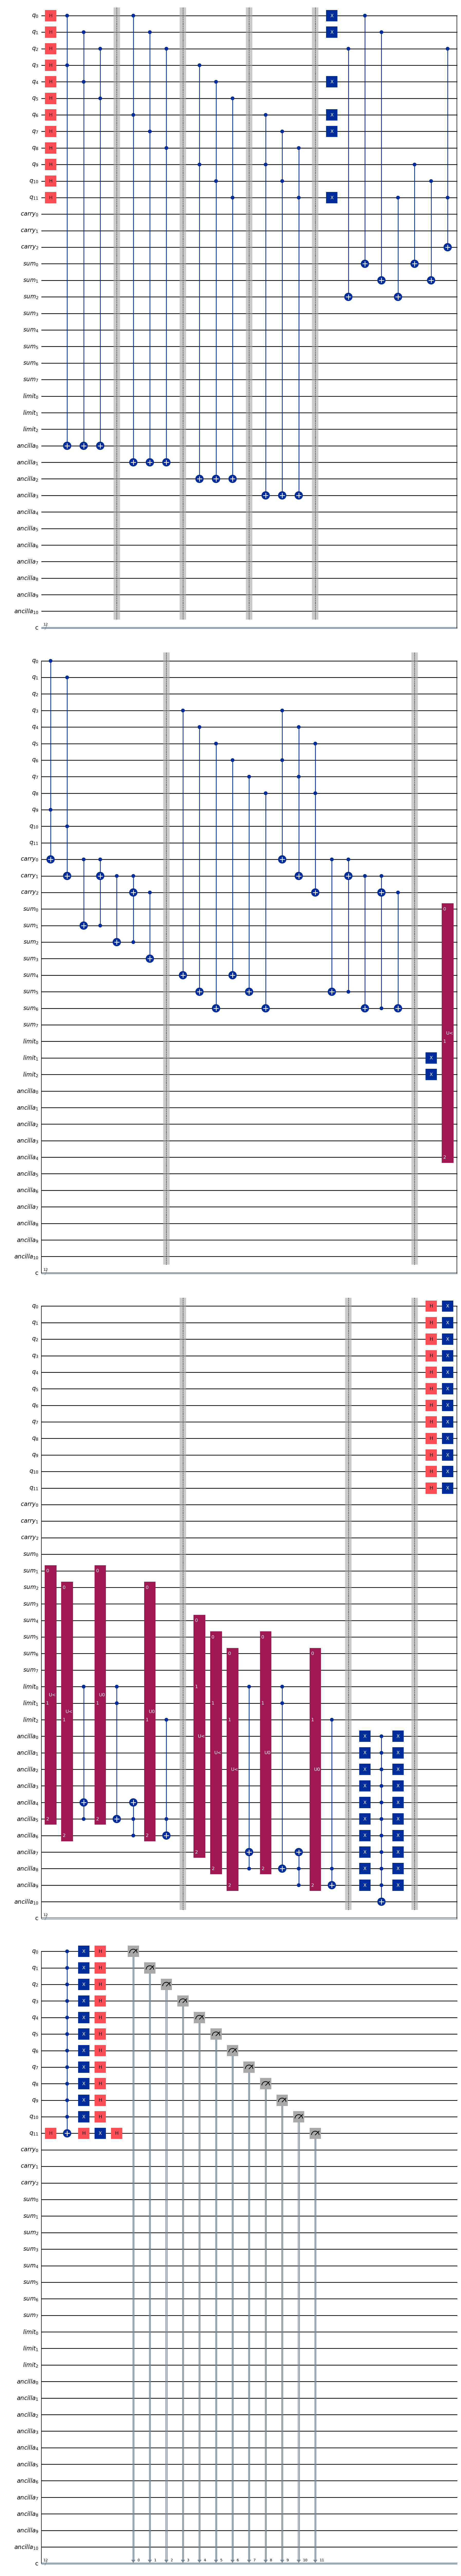

In [12]:
print(qc.draw(output='mpl'))

/var/folders/n6/vl5qkpqn5bz3lxp89nnd05h40000gn/T/ipykernel_5312/3738717666.py:20: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


{'001000100000': 3, '100011000000': 1, '111100100001': 1, '011110001100': 1, '110011000000': 5, '101100000000': 3, '011011011001': 1, '111111010000': 1, '011100010010': 1, '111010100000': 2, '001101010000': 1, '111010000000': 3, '000011000001': 5, '010111010001': 1, '011000100000': 1, '001100001000': 1, '101001000001': 3, '000100010101': 1, '110000000000': 3, '011010111100': 1, '000111000000': 2, '011100100010': 1, '011001011001': 1, '110100000100': 2, '100101100000': 1, '011110100001': 3, '100000000011': 2, '000101000101': 2, '001000000000': 2, '000000010000': 2, '110000010001': 4, '101000000011': 1, '001110010101': 1, '110010100100': 1, '010110111000': 1, '110100001000': 3, '011000010100': 1, '101100110001': 2, '111000110001': 2, '011000000001': 1, '010100010000': 1, '111110101001': 1, '110110000001': 4, '011010010001': 5, '011100101001': 1, '100011010000': 1, '001101000001': 2, '010100000000': 2, '000011001001': 1, '111100100011': 1, '001001100000': 2, '111000100001': 1, '0111000000

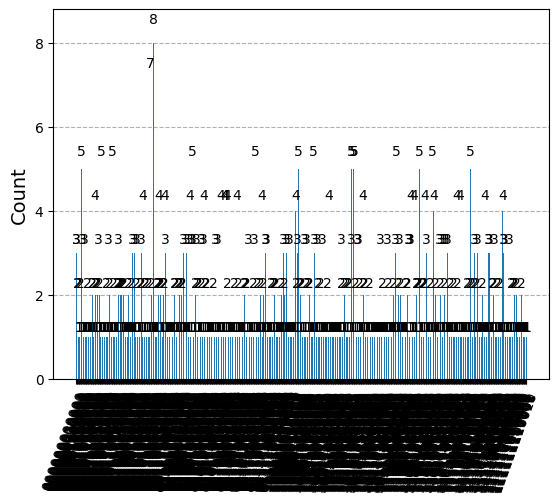

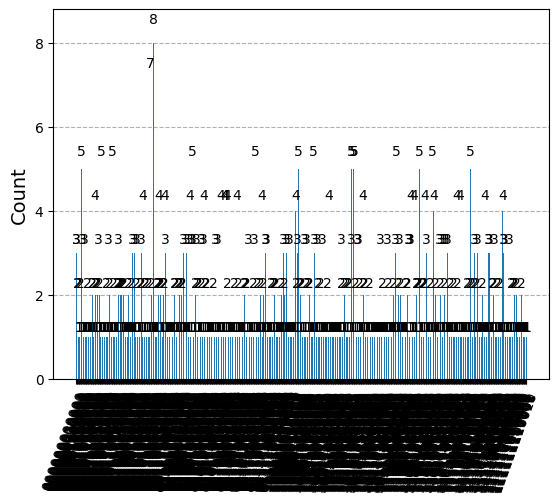

In [13]:
# Simulate the quantum circuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Replace with your actual IBM Quantum account token
IBMQ_TOKEN = "e98c2422176558d76533f39a274e33799cf0513b78932a9120c6fd9ea42c00126236a4877d0b0b0c6703da49157b08e009f684de8ba675182621b2ea2d1b9bca"

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token=IBMQ_TOKEN, set_as_default=True, overwrite=True)

# Load saved credentials
service = QiskitRuntimeService()

# Get the backend
backend = service.backend('ibm_brisbane')
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
isa_circuit = pm.run(qc)
sampler = Sampler(mode=backend) #I have change the notice below 
job = sampler.run([(isa_circuit,)], shots=1024)
job_result = job.result()
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()

# Print the results
print(counts)
plot_histogram(counts)

{'001010010000': 8, '001010000000': 7, '110011000000': 5, '000011000001': 5, '011010010001': 5, '101000010001': 5, '110001010000': 5, '000000100000': 5, '111000000001': 5, '101110000001': 5, '000100010000': 5, '010000010001': 5, '100010000000': 5, '101000000001': 5, '100000010000': 5, '101000010000': 5, '110000010001': 4, '110110000001': 4, '001011000000': 4, '101010000000': 4, '110000100001': 4, '011000000000': 4, '010000000001': 4, '001100000000': 4, '010110000000': 4, '111001110001': 4, '110110010001': 4, '100100010001': 4, '010110010000': 4, '001001000000': 4, '010010000001': 4, '111100000001': 4, '010110000001': 4, '110010000001': 4, '100000000001': 4, '011011010000': 4, '000010010000': 4, '110011000001': 4, '010101010001': 4, '001000100000': 3, '101100000000': 3, '111010000000': 3, '101001000001': 3, '110000000000': 3, '011110100001': 3, '110100001000': 3, '011100000000': 3, '000111100001': 3, '101110100000': 3, '000000000000': 3, '010001000000': 3, '000010100001': 3, '0111100100

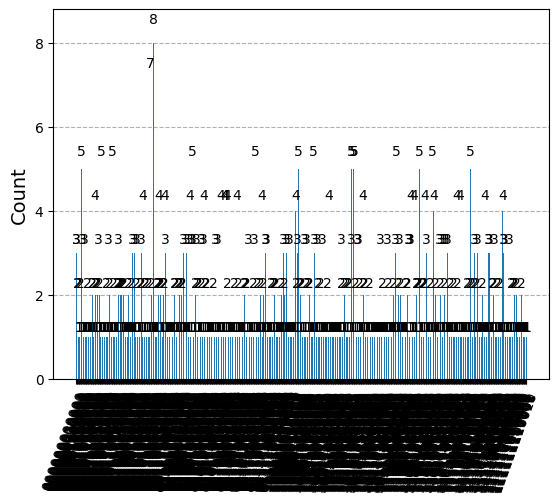

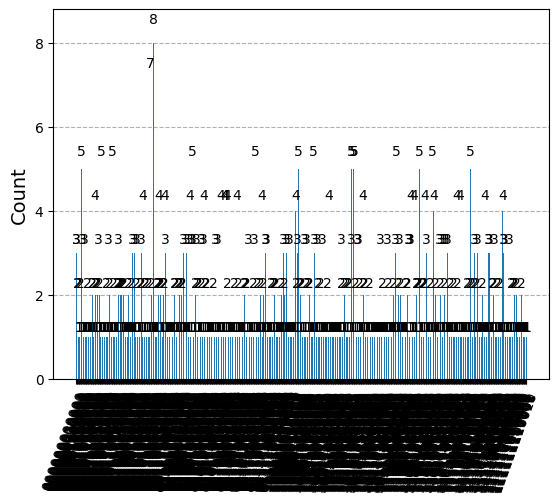

In [14]:
# Sort the results from highest to lowest probability
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Print the sorted results
print(sorted_counts)

# Plot the histogram of the sorted results
plot_histogram(sorted_counts)